In [1]:
!pip install segmentation_models
!pip install  -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


In [2]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
import os
import sys
import numpy as np
import re
import requests, io
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import segmentation_models as sm
import albumentations as A

from tqdm import tqdm
from PIL import Image
from os import listdir
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
from keras import backend as K

Segmentation Models: using `tf.keras` framework.


# Load and prepare data

In [4]:
PATH = '/kaggle/input/flood-area-segmentation/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [5]:
# data augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
])

In [6]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [7]:
df

,Image,Mask
0,/kaggle/input/flood-area-segmentation/Image/0.jpg,/kaggle/input/flood-area-segmentation/Mask/0.png
1,/kaggle/input/flood-area-segmentation/Image/1.jpg,/kaggle/input/flood-area-segmentation/Mask/1.png
2,/kaggle/input/flood-area-segmentation/Image/2.jpg,/kaggle/input/flood-area-segmentation/Mask/2.png
3,/kaggle/input/flood-area-segmentation/Image/3.jpg,/kaggle/input/flood-area-segmentation/Mask/3.png
4,/kaggle/input/flood-area-segmentation/Image/4.jpg,/kaggle/input/flood-area-segmentation/Mask/4.png
...,...,...
285,/kaggle/input/flood-area-segmentation/Image/10...,/kaggle/input/flood-area-segmentation/Mask/108...
286,/kaggle/input/flood-area-segmentation/Image/10...,/kaggle/input/flood-area-segmentation/Mask/108...
287,/kaggle/input/flood-area-segmentation/Image/10...,/kaggle/input/flood-area-segmentation/Mask/108...
288,/kaggle/input/flood-area-segmentation/Image/10...,/kaggle/input/flood-area-segmentation/Mask/108...


['/kaggle/input/flood-area-segmentation/Image/3079.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3079.png']


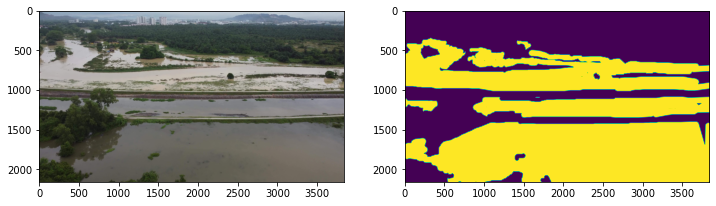

['/kaggle/input/flood-area-segmentation/Image/3046.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3046.png']


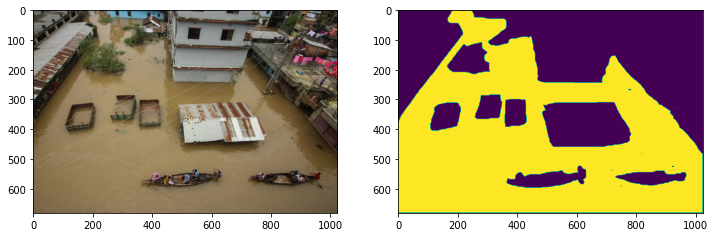

['/kaggle/input/flood-area-segmentation/Image/2038.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/2038.png']


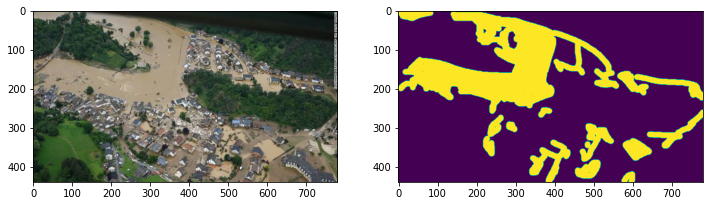

['/kaggle/input/flood-area-segmentation/Image/3055.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3055.png']


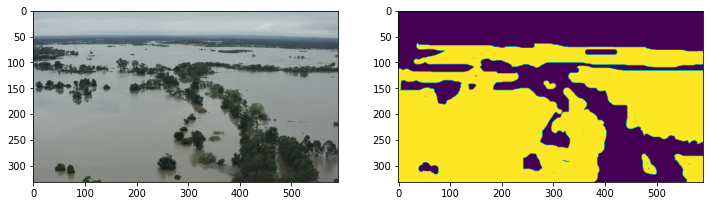

['/kaggle/input/flood-area-segmentation/Image/3070.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3070.png']


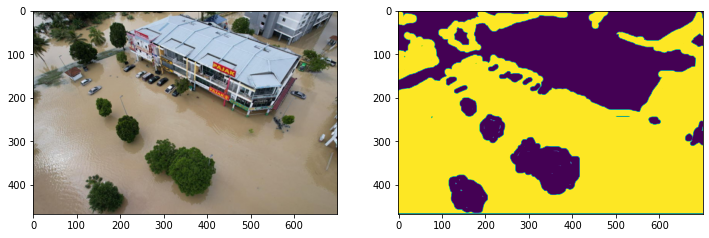

In [8]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

In [9]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >= 0.5, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    
    img = img / 255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
    
    return img.astype(np.float64), mask.astype(np.float64)

In [10]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [11]:
df_train, df_test = train_test_split(df, test_size = 0.1)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(261, 2) (29, 2)


2023-01-28 09:34:51.146230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 09:34:51.306782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 09:34:51.307906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 09:34:51.310823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# UNet

In [13]:
model = sm.Unet('efficientnetb2', 
                input_shape = (224, 224, 3), 
                classes = 1, 
                activation='sigmoid', 
                encoder_weights='imagenet')

31948800/31936256 [==============================] - 1s 0us/step


In [14]:
# model.summary()

In [15]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [16]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 15)

2023-01-28 09:34:58.235392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-28 09:35:12.563833: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 34s 775ms/step - loss: 0.5862 - iou_score: 0.4309 - val_loss: 0.4003 - val_iou_score: 0.4974
Epoch 2/15
17/17 [==============================] - 11s 596ms/step - loss: 0.3941 - iou_score: 0.5330 - val_loss: 0.3907 - val_iou_score: 0.5581
Epoch 3/15
17/17 [==============================] - 11s 644ms/step - loss: 0.3231 - iou_score: 0.5808 - val_loss: 0.3580 - val_iou_score: 0.5725
Epoch 4/15
17/17 [==============================] - 11s 623ms/step - loss: 0.2890 - iou_score: 0.6104 - val_loss: 0.3497 - val_iou_score: 0.5960
Epoch 5/15
17/17 [==============================] - 11s 657ms/step - loss: 0.2579 - iou_score: 0.6511 - val_loss: 0.3559 - val_iou_score: 0.5917
Epoch 6/15
17/17 [==============================] - 11s 589ms/step - loss: 0.2505 - iou_score: 0.6608 - val_loss: 0.4090 - val_iou_score: 0.5740
Epoch 7/15
17/17 [==============================] - 11s 666ms/step - loss: 0.2283 - iou_score: 0.6857 - val_loss: 0.4146 - val_iou_score: 0.5

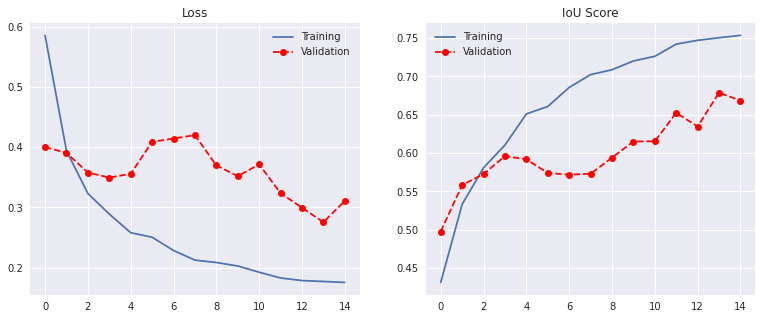

In [17]:
plt.style.use('seaborn')

plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


# FPN

In [18]:
fpn = sm.FPN('efficientnetb2', 
                input_shape = (224, 224, 3), 
                classes = 1, 
                activation='sigmoid', 
                encoder_weights='imagenet')

In [19]:
fpn.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [20]:
history = fpn.fit(train_dataset, validation_data = test_dataset, epochs = 30)

Epoch 1/30
17/17 [==============================] - 29s 810ms/step - loss: 0.4131 - iou_score: 0.5639 - val_loss: 1.4987 - val_iou_score: 0.1049
Epoch 2/30
17/17 [==============================] - 12s 684ms/step - loss: 0.2926 - iou_score: 0.6487 - val_loss: 0.5904 - val_iou_score: 0.3577
Epoch 3/30
17/17 [==============================] - 12s 651ms/step - loss: 0.2586 - iou_score: 0.6842 - val_loss: 0.3545 - val_iou_score: 0.5282
Epoch 4/30
17/17 [==============================] - 11s 630ms/step - loss: 0.2273 - iou_score: 0.7186 - val_loss: 0.3908 - val_iou_score: 0.5427
Epoch 5/30
17/17 [==============================] - 12s 610ms/step - loss: 0.2167 - iou_score: 0.7192 - val_loss: 0.3660 - val_iou_score: 0.5628
Epoch 6/30
17/17 [==============================] - 12s 697ms/step - loss: 0.2027 - iou_score: 0.7340 - val_loss: 0.3326 - val_iou_score: 0.6024
Epoch 7/30
17/17 [==============================] - 12s 688ms/step - loss: 0.2013 - iou_score: 0.7395 - val_loss: 0.3715 - val_iou

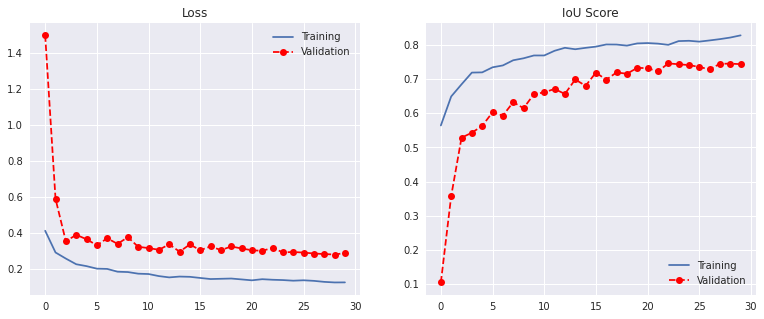

In [21]:
plt.style.use('seaborn')

plt.figure(figsize = (13, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()

# Test example

In [22]:
color = np.array([161, 205, 255]) / 255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

In [23]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img / 255.0
img = op.resize(img, (224, 224))
img = np.expand_dims(img, axis = 0)

# UNet segmentation

(-0.5, 223.5, 223.5, -0.5)

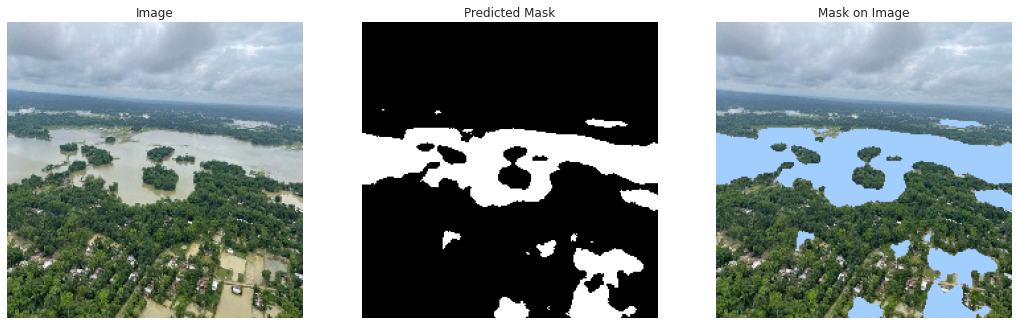

In [24]:
plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# FPN segmentation

(-0.5, 223.5, 223.5, -0.5)

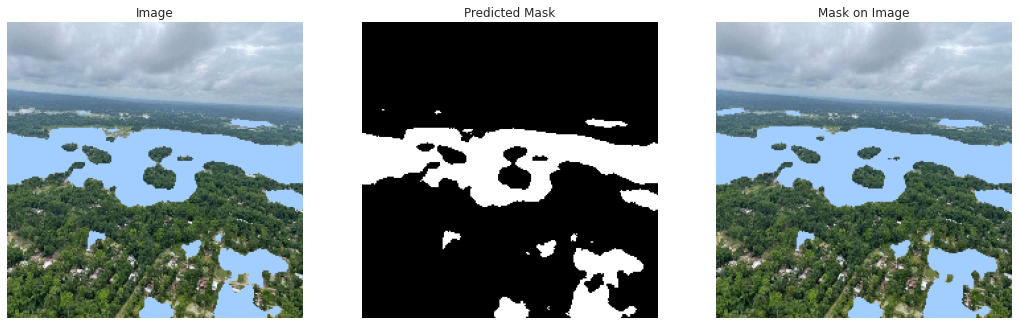

In [25]:
plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred_fpn = make_pred_good(fpn(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred_fpn))
plt.axis('off')